# Wdrażanie technik uczenia maszynowego - projekt

### Celem projektu jest wykorzystanie technik uczenia maszynowego (głównie sieci neuronowych) w celu klasyfikacji znaków drogowych. Projekt jest zrealizowany w języku Python przy użyciu takich bibliotek jak TensorFlow i PyTorch. 

#### Import najważniejszych bibliotek

In [84]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [2]:
path ='Train/'

# Parametry do resize'u obrazków.
HEIGHT = 32 
WIDTH = 32

In [3]:
class_count = len(os.listdir(train_path))
class_count #Ilość klas

43

#### Oznaczenia poszczególnych klas

In [4]:
classes = { 0:'Ograniczenie predkosci 20km/h',
            1:'Ograniczenie predkosci 30km/h', 
            2:'Ograniczenie predkosci 50km/h', 
            3:'Ograniczenie predkosci 60/h', 
            4:'Ograniczenie predkosci 70km/h', 
            5:'Ograniczenie predkosci 80km/h', 
            6:'Koniec ograniczenia prędkości (80km/h)', 
            7:'Ograniczenie predkosci 100km/h', 
            8:'Ograniczenie predkosci 120km/h', 
            9:'Zakaz wyprzedzania', 
            10:'Zakaz wyprzedzania dla pojazdów cięższych niż 3,5 t', 
            11:'Right-of-way at intersection', 
            12:'Droga z pierwszeństwem', 
            13:'Ustąp pierwszeństwa przejazdu', 
            14:'Stop', 
            15:'Zakaz wjazdu pojazdów silnikowych', 
            16:'Zakaz wjazdu samochodów ciężarowych o masie przekraczającej 3,5t', 
            17:'Zakaz wjazdu', 
            18:'Uwaga', 
            19:'Niebezpieczny skręt w lewo', 
            20:'Niebezpieczny skręt w prawo', 
            21:'Dwa niebezpieczne zakręty', 
            22:'Wyboista droga', 
            23:'Śliska jezdnia', 
            24:'Zwężenie jezdni prawostronne', 
            25:'Roboty drogowe', 
            26:'Sygnalizacja świetlna', 
            27:'Piesi', 
            28:'Uwaga dzieci', 
            29:'Przejazd dla rowerzystów', 
            30:'Lód na drodze',
            31:'Dzikie zwierzęta', 
            32:'Koniec ograniczenia prędkości', 
            33:'Nakaz jazdy w prawo', 
            34:'Nakaz jazdy w lewo', 
            35:'Nakaz jazdy prosto', 
            36:'Nakaz jazdy prosto lub w prawo', 
            37:'Nakaz jazdy prosto lub w lewo', 
            38:'Trzymaj się prawej strony', 
            39:'Trzymaj się lewej strony', 
            40:'Ruch okrężny', 
            41:'Koniec zakazu wyprzedzania', 
            42:'Koniec zakazu wyprzedzania dla pojazdów cięższych niż 3,5 t' }

#### Prezentacja danych (ilośc obrazków w poszczególnych klasach)

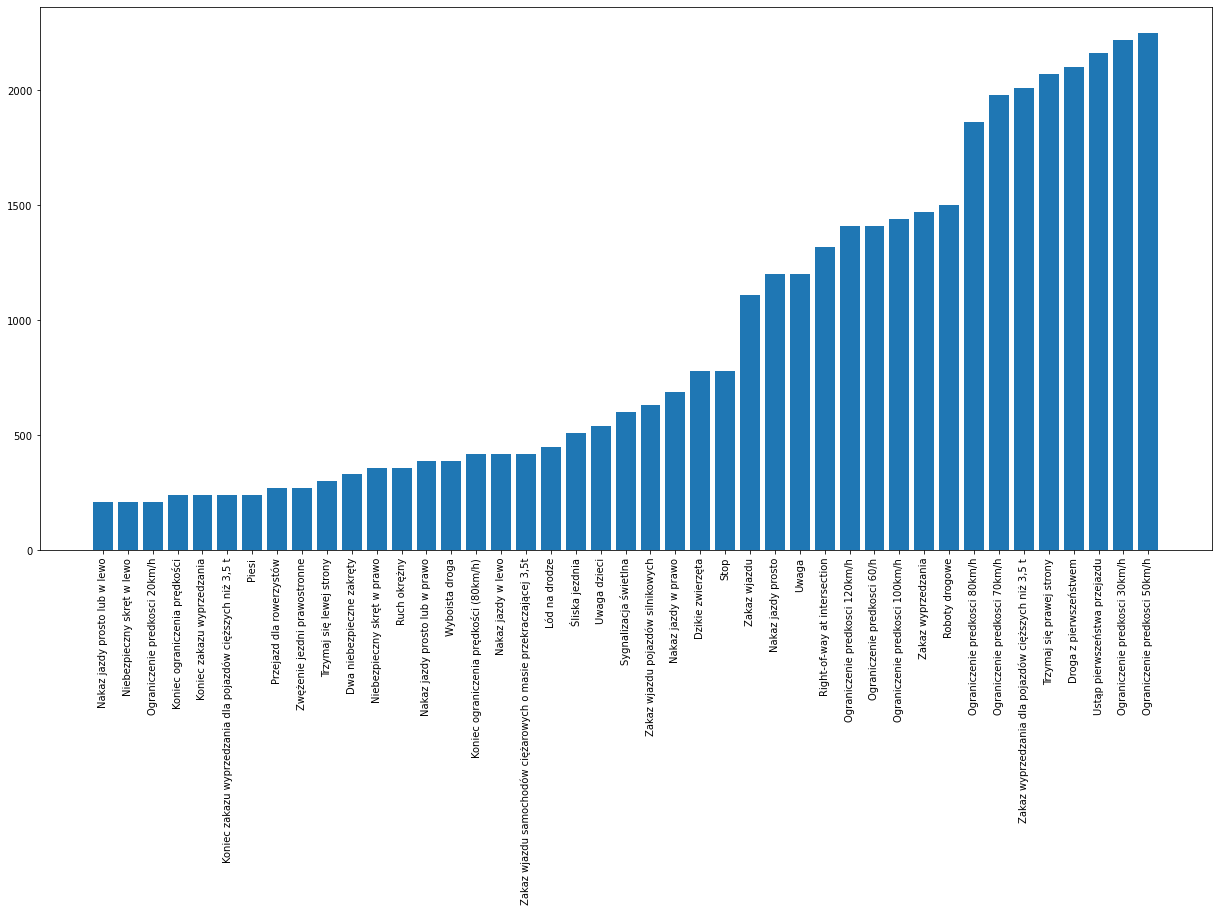

In [5]:
folders = os.listdir(path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## TensorFlow

#### Augumentacja danych

In [7]:
image_data = []
image_labels = []

for i in range(class_count):
    path = 'Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        image = cv2.imread(path + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((HEIGHT, WIDTH))
        image_data.append(np.array(resize_image))
        image_labels.append(i)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


#### Podział zbioru na trening i test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_test = X_test/255

In [9]:
y_train = keras.utils.to_categorical(y_train, class_count)
y_test = keras.utils.to_categorical(y_val, class_count)

#### Model sieci neuronowej

In [10]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(HEIGHT,WIDTH,3)),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 512)               1843712   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

#### Trenowanie modelu

In [11]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
batch_size=128
epochs=10
history = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
215/215 [==============================] - 8s 37ms/step - loss: 0.8331 - accuracy: 0.7828 - val_loss: 2.4602 - val_accuracy: 0.4090
Epoch 2/10
215/215 [==============================] - 8s 36ms/step - loss: 0.1519 - accuracy: 0.9592 - val_loss: 0.6970 - val_accuracy: 0.9022
Epoch 3/10
215/215 [==============================] - 7s 35ms/step - loss: 0.0855 - accuracy: 0.9770 - val_loss: 0.1053 - val_accuracy: 0.9792
Epoch 4/10
215/215 [==============================] - 7s 34ms/step - loss: 0.0611 - accuracy: 0.9842 - val_loss: 0.0716 - val_accuracy: 0.9812
Epoch 5/10
215/215 [==============================] - 8s 36ms/step - loss: 0.0387 - accuracy: 0.9908 - val_loss: 0.0600 - val_accuracy: 0.9821
Epoch 6/10
215/215 [==============================] - 8s 35ms/step - loss: 0.0300 - accuracy: 0.9929 - val_loss: 0.0581 - val_accuracy: 0.9838
Epoch 7/10
215/215 [==============================] - 8s 35ms/step - loss: 0.0356 - accuracy: 0.9910 - val_loss: 0.0698 - val_accuracy: 0.9808

#### Prezentacja wyników

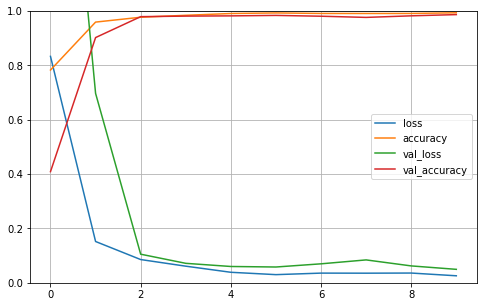

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
cf = confusion_matrix(y_test_arg, Y_pred)

Confusion Matrix
[[ 50   3   0 ...   0   0   0]
 [  1 695   4 ...   0   0   0]
 [  0   4 675 ...   0   0   0]
 ...
 [  0   0   0 ... 104   0   0]
 [  0   0   0 ...   2  68   0]
 [  0   0   0 ...   0   0  67]]


<AxesSubplot:>

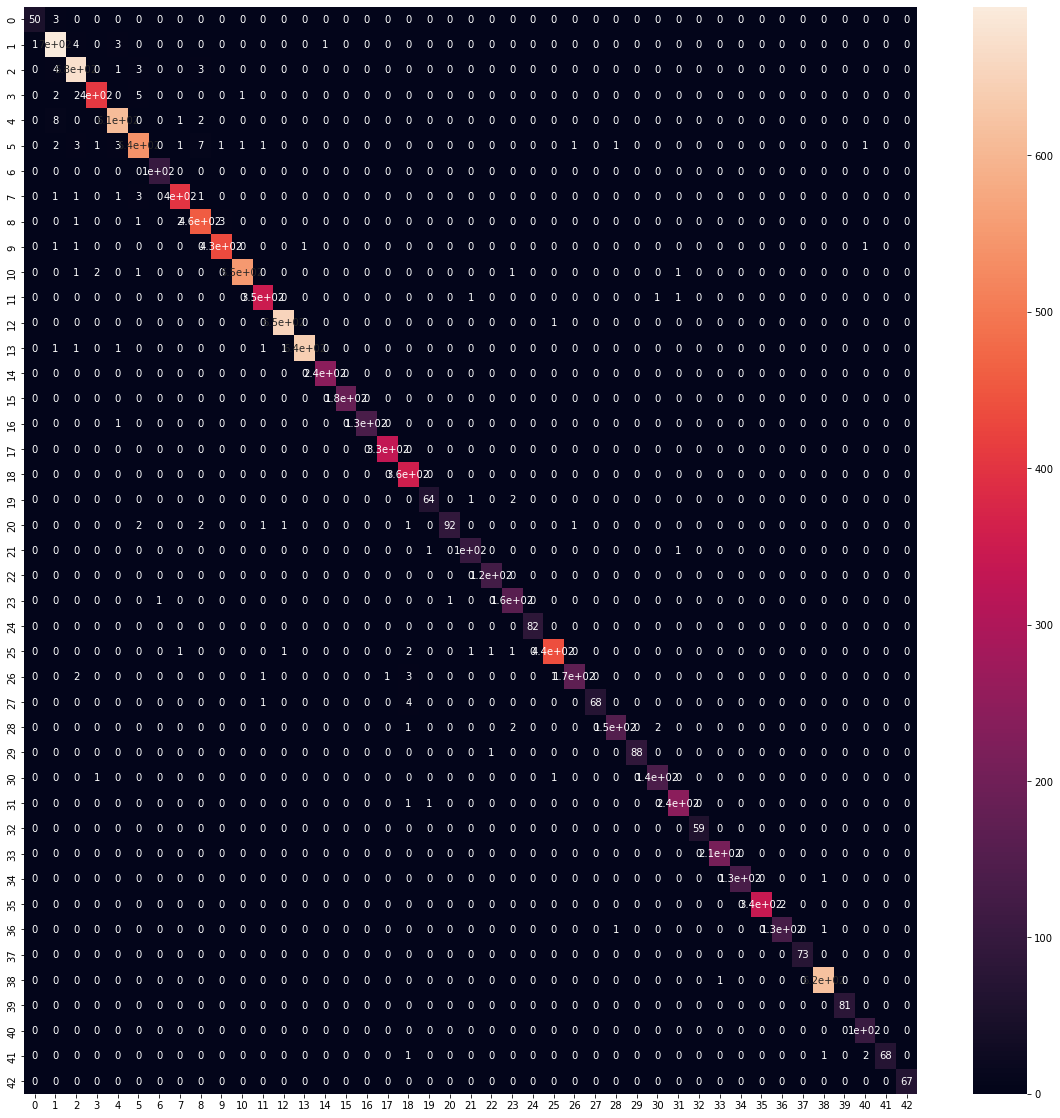

In [29]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        53
           1       0.97      0.99      0.98       704
           2       0.98      0.98      0.98       686
           3       0.99      0.98      0.98       415
           4       0.98      0.98      0.98       620
           5       0.97      0.96      0.97       562
           6       0.99      1.00      1.00       101
           7       0.99      0.98      0.99       408
           8       0.97      0.98      0.98       464
           9       0.99      0.99      0.99       437
          10       1.00      0.99      0.99       556
          11       0.99      0.99      0.99       351
          12       1.00      1.00      1.00       654
          13       1.00      0.99      1.00       647
          14       1.00      1.00      1.00       242
          15       1.00      1.00      1.00       184
          16       1.00      0.99      1.00       135
          17       1.00    

### Wykorzystanie transfer learningu za pomocą biblioteki PyTorch

In [69]:
IMAGENET_MEANS = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [70]:
transforms_compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([HEIGHT, WIDTH]),
    transforms.Normalize(IMAGENET_MEANS, IMAGENET_STD)
])

In [71]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data = ImageFolder('Train', transform = transforms_compose)
n_test = int(np.floor(0.2 * len(data)))
n_train = len(data) - n_val

train_ds, test_ds = random_split(data, [n_train, n_test])

In [72]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

#### Trening z wykorzystaniem pretrenowanej sieci neuronowej ResNet18 (z wagami pretrenowanymi)

In [73]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        epoch_loss = loss_train / len(train_loader)
        print(f"Epoch {epoch}, Training loss {epoch_loss}")

In [74]:
# sprawdzenie, czy GPU jest widoczne
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [75]:
from torchvision import models
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)
model = model.to(device=device)

In [76]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 3,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

Epoch 1, Training loss 1.3901887026017274
Epoch 2, Training loss 0.3235824684786603
Epoch 3, Training loss 0.10208560041023221


#### Testowanie

In [79]:
def validate(model, train_loader, val_loader):
    model.eval()
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1)
                total += labels.shape[0]
                correct += int((preds == labels).sum())
                
        print(f"{name} accuracy: {correct/total}")

In [78]:
validate(model, train_loader, val_loader)

train accuracy: 0.9911374649324152
val accuracy: 0.9658206861369724
